In [1]:
import os
import imageio
import subprocess
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.collections import PatchCollection

In [2]:
def load_data(filename):
    boxes = pd.read_csv(filename, header=None, names=['Youtube ID', 'Timestamp', 'x', 'y', 'w', 'h', 'id']) #.as_matrix() 
    
    return boxes 
    
data = load_data('train_test_val_merged_detections_v2_ts_fixed.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045698 entries, 0 to 4045697
Data columns (total 7 columns):
Youtube ID    object
Timestamp     int64
x             float64
y             float64
w             float64
h             float64
id            object
dtypes: float64(4), int64(1), object(2)
memory usage: 216.1+ MB
None


In [3]:
print(data.groupby('Youtube ID').count())

             Timestamp      x      y      w      h     id
Youtube ID                                               
-KUYDYCwnOQ      15906  15906  15906  15906  15906  15906
-VcfnuYRhMU      14258  14258  14258  14258  14258  14258
-XPEvIMe05A      17608  17608  17608  17608  17608  17608
-lr_jc5fWqA      15414  15414  15414  15414  15414  15414
-pjofDnW8fU      12864  12864  12864  12864  12864  12864
-tjwPDcBe74      12133  12133  12133  12133  12133  12133
0En5pOUZN5M      17112  17112  17112  17112  17112  17112
0VhsXKRmKfU      20775  20775  20775  20775  20775  20775
0aWfrZAM6Q8      11587  11587  11587  11587  11587  11587
0ntRJpD2fM8      21344  21344  21344  21344  21344  21344
21jvt4T1o7Q      12351  12351  12351  12351  12351  12351
2H45XQEjFQ8      18000  18000  18000  18000  18000  18000
2fw2DEqZZQk      22534  22534  22534  22534  22534  22534
2zBswlkuSFI      12408  12408  12408  12408  12408  12408
34pDYPRZie4      17208  17208  17208  17208  17208  17208
3N80KGqyXDw   

In [59]:
from __future__ import unicode_literals
import youtube_dl

ydl_opts = {'format': 'mp4', 'outtmpl': 'videos/%(id)s.mp4', 'restrictfilenames': True}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    for vid_id in data['Youtube ID'].unique()[5:20]:
        ydl.download(["http://youtube.com/watch?v="+str(vid_id)])

[youtube] -tjwPDcBe74: Downloading webpage
[youtube] -tjwPDcBe74: Downloading video info webpage
[youtube] -tjwPDcBe74: Extracting video information
[download] Destination: videos/-tjwPDcBe74.mp4
[download] 100% of 388.77MiB in 00:3663MiB/s ETA 00:009
[youtube] 0En5pOUZN5M: Downloading webpage
[youtube] 0En5pOUZN5M: Downloading video info webpage
[youtube] 0En5pOUZN5M: Extracting video information
[download] Destination: videos/0En5pOUZN5M.mp4
[download] 100% of 1.41GiB in 02:0289MiB/s ETA 00:006:43
[youtube] 0VhsXKRmKfU: Downloading webpage
[youtube] 0VhsXKRmKfU: Downloading video info webpage
[youtube] 0VhsXKRmKfU: Extracting video information
[download] Destination: videos/0VhsXKRmKfU.mp4
[download] 100% of 416.19MiB in 00:4867MiB/s ETA 00:005:42
[youtube] 0aWfrZAM6Q8: Downloading webpage
[youtube] 0aWfrZAM6Q8: Downloading video info webpage
[youtube] 0aWfrZAM6Q8: Extracting video information
[download] Destination: videos/0aWfrZAM6Q8.mp4
[download] 100% of 365.03MiB in 00:4770MiB/s

videos/-KUYDYCwnOQ.mp4


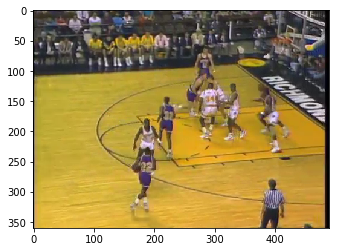

In [26]:
def get_video_info(vid_id):
    filename = 'videos/%s.mp4' % str(vid_id)
    command = ['ffprobe',
               '-v', 'fatal',
               '-show_entries', 'stream=width,height,r_frame_rate,duration',
               '-of', 'default=noprint_wrappers=1:nokey=1',
               filename, '-sexagesimal']
    ffmpeg = subprocess.Popen(command, stderr=subprocess.PIPE ,stdout = subprocess.PIPE )
    out, err = ffmpeg.communicate()
    if(err) : print(err)
    out = out.decode("utf-8").split('\n')
    return {'file' : filename,
            'width': int(out[0]),
            'height' : int(out[1]),
            'fps': float(out[2].split('/')[0])/float(out[2].split('/')[1]),
            'duration' : out[3] }


def read_frame(filename, ts, num_frame, t_w, t_h) :
    command = ['ffmpeg',
               '-loglevel', 'fatal',
               '-ss', str(datetime.timedelta(seconds=ts*1e-6)),
               '-i', filename,
               '-threads', str(4),
               '-vf', 'scale=%d:%d'%(t_w,t_h),
               '-vframes', str(num_frame),
               '-f', 'image2pipe',
               '-pix_fmt', 'rgb24',
               '-vcodec', 'rawvideo', '-']

    ffmpeg = subprocess.Popen(command, stderr=subprocess.PIPE ,stdout = subprocess.PIPE )
    out, err = ffmpeg.communicate()
    if(err) : print('error',err); return None;
    
    video = np.fromstring(out, dtype='uint8').reshape((num_frame, t_h, t_w, 3)) #NHWC
    return video

info = get_video_info(data['Youtube ID'].unique()[0])
frame = read_frame(info['file'], 518684833, 1, info['width'], info['height'])

plt.imshow(frame[0])
plt.show()

(360, 490, 3)


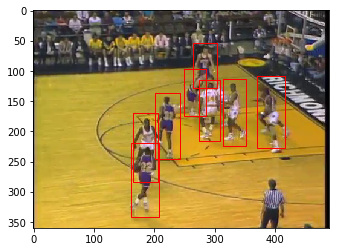

In [57]:
def format_bb(x1, y1, w, h, fw, fh):
    return (x1*fw, y1*fh), w*fw, h*fh
    
    
def show_img_bb(vid_id, ts, num_frames, df):
    info = get_video_info(vid_id)
    frame = read_frame(info['file'], ts, num_frames, info['width'], info['height'])[0]
    bbs = df.loc[(df['Youtube ID'] == vid_id) & (df['Timestamp'] == ts)] 
    print(frame.shape)
    fig, ax = plt.subplots(1)
    ax.imshow(frame)
    boxes = []
    for index, row in bbs.iterrows():
        xy, w, h = format_bb(row['x'], row['y'], row['w'], row['h'], info['width'], info['height'])
        rect = patches.Rectangle(xy, w, h)
        boxes.append(rect)
    
    ax.add_collection(PatchCollection(boxes, linewidth=1, edgecolor='r', facecolor='None'))
    plt.show()
    
show_img_bb(data['Youtube ID'].unique()[0], 518684833, 1, data)

In [53]:
dims = set()

for vid_id in data['Youtube ID'].unique()[:5]:
    info = get_video_info(vid_id)
    dims.add((info['height'], info['width']))

In [58]:
print(len(data['Youtube ID'].unique()))

257
